###### data collected from: https://www.kaggle.com/code/satishgunjal/mining-mastering-the-art-of-english-corrections

In [1]:
# load those needed packages and libraries
import torch
import optuna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import SmoothingFunction
from transformers import T5Tokenizer, T5ForConditionalGeneration

# set the device to cuda if available else cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the dataset
text_df = pd.read_csv("Grammar_Correction.csv")

In [2]:
# display the first 10 rows of the dataset to understand the data structure and format of the dataset
text_df.head(10)

,Serial Number,Error Type,Ungrammatical Statement,Standard English
0,1,Verb Tense Errors,I goes to the store everyday.,I go to the store everyday.
1,2,Verb Tense Errors,They was playing soccer last night.,They were playing soccer last night.
2,3,Verb Tense Errors,She have completed her homework.,She has completed her homework.
3,4,Verb Tense Errors,He don't know the answer.,He doesn't know the answer.
4,5,Verb Tense Errors,The sun rise in the east.,The sun rises in the east.
5,6,Verb Tense Errors,I am eat pizza for lunch.,I am eating pizza for lunch.
6,7,Verb Tense Errors,The students studies for the exam.,The students study for the exam.
7,8,Verb Tense Errors,The car need to be repaired.,The car needs to be repaired.
8,9,Verb Tense Errors,She will goes to the party tonight.,She will go to the party tonight.
9,10,Verb Tense Errors,They watches the movie together.,They watch the movie together.


Text(0, 0.5, 'Error Type')

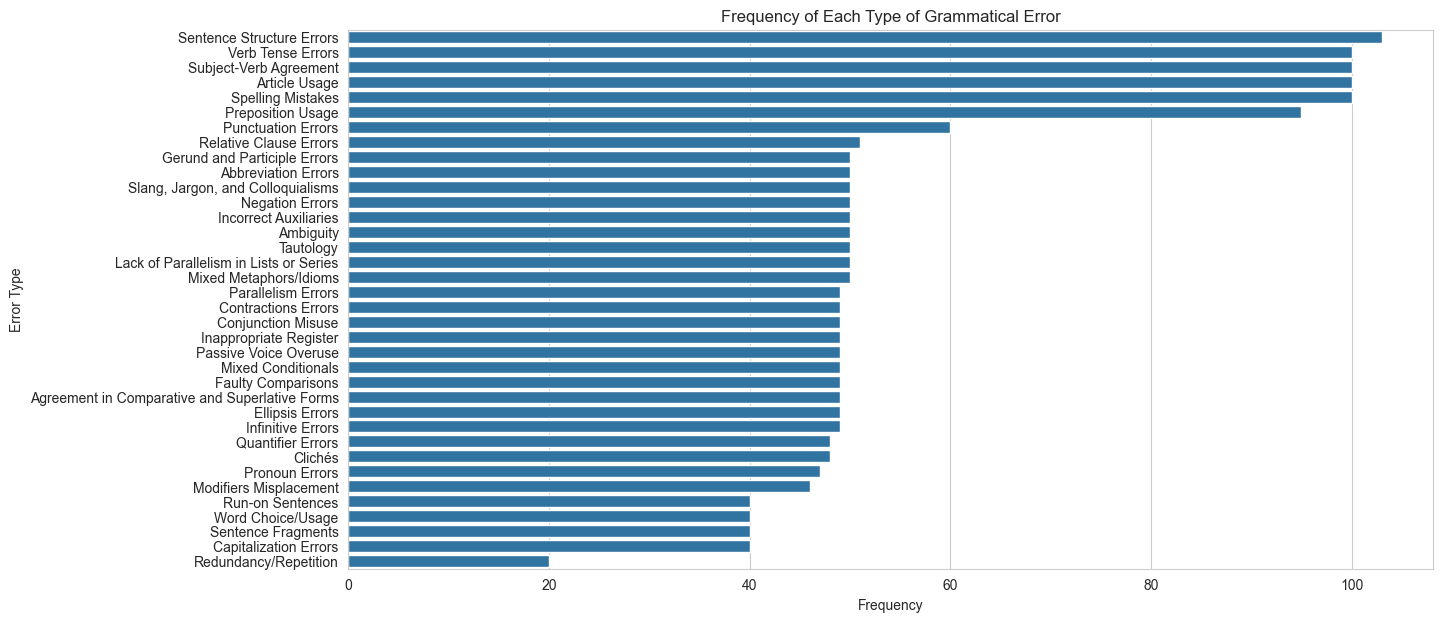

In [20]:
# display the shape of the dataset to understand the number of rows and columns in the dataset
sns.set_style("whitegrid")
plt.figure(figsize = (14, 7))
error_type_plot = sns.countplot(y = text_df["Error Type"], order = text_df["Error Type"].value_counts().index)
error_type_plot.set_title("Frequency of Each Type of Grammatical Error")
error_type_plot.set_xlabel("Frequency")
error_type_plot.set_ylabel("Error Type")

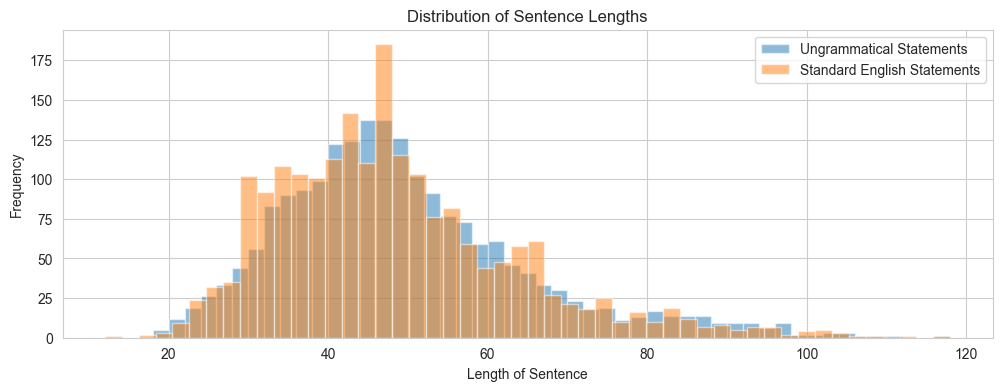

In [22]:
# add the length of the ungrammatical and standard English statements to the dataset
text_df["Ungrammatical Length"] = text_df["Ungrammatical Statement"].apply(len)
text_df["Standard Length"] = text_df["Standard English"].apply(len) 

# display the distribution of sentence lengths for the ungrammatical and standard English statements
plt.figure(figsize = (12, 4))
plt.hist(text_df["Ungrammatical Length"], bins = 50, alpha = 0.5, label = "Ungrammatical Statements")
plt.hist(text_df["Standard Length"], bins = 50, alpha = 0.5, label = "Standard English Statements")
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Length of Sentence")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [3]:
# load the pre-trained T5 model and tokenizer from the Hugging Face Transformers library and set the shared parameters (as freezing those parameters defined during the pre-trained stage to avoid catastrophic forgetting) to False
model = T5ForConditionalGeneration.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# set the shared parameters to False
for param in model.shared.parameters():
    param.requires_grad = False

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
# define the GrammarCorrectionDataset class for the dataset
class GrammarCorrectionDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    # return the ungrammatical statement and the standard English statement
    def __getitem__(self, idx):
        ungrammatical_statement = self.dataframe.iloc[idx]["Ungrammatical Statement"]
        standard_english = self.dataframe.iloc[idx]["Standard English"]
        return ungrammatical_statement, standard_english

In [5]:
# split the dataset into training, validation, and test sets with 80%, 10%, and 10%
train_df, test_df = train_test_split(text_df, test_size = 0.2)
train_df, val_df = train_test_split(train_df, test_size = 0.1)

# create the GrammarCorrectionDataset for the training, validation, and test sets
train_dataset = GrammarCorrectionDataset(train_df)
val_dataset = GrammarCorrectionDataset(val_df)
test_dataset = GrammarCorrectionDataset(test_df)

In [6]:
# create the DataLoaders for the training, validation, and test sets
model = model.to(device)
# set the model to training mode
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
# initialize the scheduler
scheduler = StepLR(optimizer, step_size = 1, gamma = 0.1)

In [ ]:
# define the train_epoch function to train the model for one epoch
def train_epoch(model, dataloader, optimizer, device, scheduler):
    # set the model to the device
    model = model.to(device)
    # set the model to training mode
    model.train()
    # initialize the total loss to 0
    total_loss = 0
    # iterate over the dataloader to get the ungrammatical statement and the standard English statement
    for ungrammatical_statement, standard_english in dataloader:
        # move the inputs and labels to the device, set the configuration for the tokenizer, and get the outputs from the model
        inputs = tokenizer(ungrammatical_statement, return_tensors = "pt", padding = True, truncation=True, max_length = 256).to(device)
        labels = tokenizer(standard_english, return_tensors = "pt", padding = True, truncation = True, max_length = 256).input_ids.to(device)
        outputs = model(**inputs, labels = labels)
        # get the loss from the outputs and add it to the total loss
        loss = outputs.loss
        total_loss += loss.item()
        # backpropagate the loss and update the optimizer
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # update the scheduler
    scheduler.step()
    # calculate the average loss
    average_loss = total_loss / len(dataloader)
    return average_loss

In [10]:
# define the eval_model function to evaluate the model on the validation or test set
def eval_model(model, dataloader, device):
    # set the model to the device
    model = model.to(device)
    # set the model to evaluation mode
    model.eval()
    # initialize the total BLEU score to 0
    total_bleu_score = 0
    # set the smoothing function to method1
    smoothing = SmoothingFunction().method1
    with torch.no_grad():
        # iterate over the dataloader to get the ungrammatical statement and the standard English statement
        for ungrammatical_statement, standard_english in dataloader:
            # move the inputs and labels to the device, set the configuration for the tokenizer, and get the outputs from the model
            inputs = tokenizer(ungrammatical_statement, return_tensors = "pt", padding = True, truncation = True, max_length = 256).to(device)
            labels = tokenizer(standard_english, return_tensors = "pt", padding = True, truncation = True, max_length = 256).input_ids.to(device)
            outputs = model.generate(**inputs, max_new_tokens = 256)
            # decode the outputs and calculate the BLEU score
            corrected_english = tokenizer.decode(outputs[0], skip_special_tokens = True)
            reference = [standard_english[0].split()]
            candidate = corrected_english.split()
            bleu_score = sentence_bleu(reference, candidate, smoothing_function = smoothing)
            total_bleu_score += bleu_score
    average_bleu_score = total_bleu_score / len(dataloader)
    print(average_bleu_score)
    return average_bleu_score

In [11]:
# using optuna to tune the hyperparameters of the model and optimizer to improve the BLEU score on the validation set with 10 trials
def objective(trial):
    # define the hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)
    num_train_epochs = trial.suggest_int("num_train_epochs", 1, 5)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16, 32])
    
    # load the pre-trained T5 model and tokenizer from the Hugging Face Transformers library
    tokenizer = T5Tokenizer.from_pretrained("t5-base")
    model = T5ForConditionalGeneration.from_pretrained("t5-base")
    # set the shared parameters to False
    for param in model.shared.parameters():
        param.requires_grad = False
    
    # set the optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler = StepLR(optimizer, step_size = 1, gamma = 0.1)

    # create the DataLoaders for the training and validation
    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

    # train the model for the specified number of epochs
    for epoch in range(num_train_epochs):
        # train the model for one epoch and print the average loss
        average_loss = train_epoch(model, train_dataloader, optimizer, device, scheduler)
        print(f"Epoch: {epoch+1}, Loss: {average_loss}")
        eval_model(model, val_dataloader, device)

    # evaluate the model with the validation set and return the average BLEU score
    average_bleu_score = eval_model(model, test_dataloader, device)
    return average_bleu_score

# create a study and optimize the objective function with 5 trials
study = optuna.create_study(direction = "maximize", pruner = optuna.pruners.MedianPruner())
study.optimize(objective, n_trials = 5)
# print the best hyperparameters
print(study.best_params)

[I 2024-06-23 15:39:03,886] A new study created in memory with name: no-name-6424f19e-3a5f-4ddb-9e73-c68598efdf6d
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch: 1, Loss: 4.158945128157899
0.36954437689416
Epoch: 2, Loss: 2.9482266843973934
0.25591153646324055
0.395018168120822


[I 2024-06-23 15:54:30,556] Trial 0 finished with value: 0.395018168120822 and parameters: {'learning_rate': 3.318639354440715e-06, 'num_train_epochs': 2, 'batch_size': 8}. Best is trial 0 with value: 0.395018168120822.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch: 1, Loss: 1.8784932312758074
0.7040027258512728
0.514860043391952


[I 2024-06-23 15:58:24,815] Trial 1 finished with value: 0.514860043391952 and parameters: {'learning_rate': 5.4659940164969076e-05, 'num_train_epochs': 1, 'batch_size': 32}. Best is trial 1 with value: 0.514860043391952.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch: 1, Loss: 2.8328595039929896
0.345625450345255
Epoch: 2, Loss: 1.5300201809767522
0.3276594191925708
0.42560615014196473


[I 2024-06-23 20:10:38,418] Trial 2 finished with value: 0.42560615014196473 and parameters: {'learning_rate': 3.746132711051567e-06, 'num_train_epochs': 2, 'batch_size': 4}. Best is trial 1 with value: 0.514860043391952.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch: 1, Loss: 5.937150260676509
0.3746813381108502
Epoch: 2, Loss: 5.150656430617623
0.23549473077972652
Epoch: 3, Loss: 5.025063893069392
0.524521046059088
0.3716401030626949


[I 2024-06-23 20:19:42,806] Trial 3 finished with value: 0.3716401030626949 and parameters: {'learning_rate': 4.25541622006629e-06, 'num_train_epochs': 3, 'batch_size': 32}. Best is trial 1 with value: 0.514860043391952.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch: 1, Loss: 6.241667680118395
0.3425800631214894
Epoch: 2, Loss: 5.657695303792539
0.288359230060559
Epoch: 3, Loss: 5.654184476188991
0.31325426847782406
Epoch: 4, Loss: 5.674662030261496
0.30105162063339236
0.3877743945591565


[I 2024-06-23 20:31:08,674] Trial 4 finished with value: 0.3877743945591565 and parameters: {'learning_rate': 2.685538268283178e-06, 'num_train_epochs': 4, 'batch_size': 32}. Best is trial 1 with value: 0.514860043391952.


{'learning_rate': 5.4659940164969076e-05, 'num_train_epochs': 1, 'batch_size': 32}


In [12]:
# load the pre-trained T5 model and tokenizer
model = T5ForConditionalGeneration.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# set the shared parameters to False
for param in model.shared.parameters():
    param.requires_grad = False
    
# set the device to cuda if available else cpu
model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [14]:
# get the best hyperparameters from the study
learning_rate = study.best_params["learning_rate"]
num_train_epochs = study.best_params["num_train_epochs"]
per_device_train_batch_size = study.best_params["batch_size"]

# set the optimizer and scheduler with the best hyperparameters
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = StepLR(optimizer, step_size = 1, gamma = 0.1)

# create the DataLoaders for the training, validation, and test sets with the best hyperparameters (the batch size)
train_dataloader = DataLoader(train_dataset, batch_size = per_device_train_batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = per_device_train_batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = per_device_train_batch_size, shuffle = True)

# train the model for the specified number of epochs with the best hyperparameters and evaluate the model on the validation and test sets
for epoch in range(num_train_epochs):
    average_loss = train_epoch(model, train_dataloader, optimizer, device, scheduler)
    print(f"Epoch: {epoch+1}, Loss: {average_loss}")
    eval_model(model, val_dataloader, device)

# evaluate the model on the test set with the best hyperparameters and print the average BLEU score
eval_model(model, test_dataloader, device)

Epoch: 1, Loss: 1.8484593085620715
0.6237771250424272
0.6546422658052603


0.6546422658052603

In [15]:
# implement the fine-tuned model on the dataset to correct the ungrammatical statements
def correct_grammar(model, ungrammatical_statement):
    # set the model to evaluation
    model.eval()
    # tokenize the ungrammatical statement and get the outputs from the model
    inputs = tokenizer(ungrammatical_statement, return_tensors = "pt", padding = True, truncation = True, max_length = 256).to(device)
    outputs = model.generate(**inputs, max_new_tokens = 256)
    # decode the outputs and return the corrected English statement
    corrected_english = tokenizer.decode(outputs[0], skip_special_tokens = True)
    return corrected_english

# correct the ungrammatical statements in the dataset
text_df["Corrected English"] = text_df["Ungrammatical Statement"].apply(lambda x: correct_grammar(model, x))

In [16]:
text_df.head(10)

,Serial Number,Error Type,Ungrammatical Statement,Standard English,Corrected English
0,1,Verb Tense Errors,I goes to the store everyday.,I go to the store everyday.,I go to the store everyday.
1,2,Verb Tense Errors,They was playing soccer last night.,They were playing soccer last night.,They were playing soccer last night.
2,3,Verb Tense Errors,She have completed her homework.,She has completed her homework.,She has completed her homework.
3,4,Verb Tense Errors,He don't know the answer.,He doesn't know the answer.,He don't know the answer.
4,5,Verb Tense Errors,The sun rise in the east.,The sun rises in the east.,The sun rise in the east.
5,6,Verb Tense Errors,I am eat pizza for lunch.,I am eating pizza for lunch.,I am eat pizza for lunch.
6,7,Verb Tense Errors,The students studies for the exam.,The students study for the exam.,The students study for the exam.
7,8,Verb Tense Errors,The car need to be repaired.,The car needs to be repaired.,The car needs to be repaired.
8,9,Verb Tense Errors,She will goes to the party tonight.,She will go to the party tonight.,She will go to the party tonight.
9,10,Verb Tense Errors,They watches the movie together.,They watch the movie together.,They watch the movie together.
